In [1]:
import pygmsh
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.sparse import lil_matrix
from scipy.sparse.linalg import spsolve
import time
import re

import pygmsh
import meshio

class Mesh:
    def __init__(self):
        self.POS = None
        self.BDY = None
        self.TRI = None

# Definición de las mallas

In [3]:
def pygmsh_cuadrado(lc = 0.2):
    """
    Genera con pygmsh una malla de un circulo.
    """

    with pygmsh.geo.Geometry() as geom:
        # ---------------------------
        # Parámetros
        L = 1.0
        # ---------------------------
        # Crear puntos cuadrado
        p0 = geom.add_point([ 0, 0, 0], lc)
        p1 = geom.add_point([ L, 0, 0], lc)
        p2 = geom.add_point([ L, L, 0], lc)
        p3 = geom.add_point([ 0, L, 0], lc)
        # ---------------------------
        # Crear lineas
        c1 = geom.add_line(p0, p1)
        c2 = geom.add_line(p1, p2)
        c3 = geom.add_line(p2, p3)
        c4 = geom.add_line(p3, p0)
        # ---------------------------
        # Crear loop cerrado
        loop1 = geom.add_curve_loop([c1, c2, c3, c4])
        # ---------------------------
        # Crear superficie
        surf = geom.add_plane_surface(loop1)
        # ---------------------------
        # Generar malla
        mesh = geom.generate_mesh()

    return mesh

In [4]:
def pygmsh_circulo(lc = 0.2):
    """
    Genera con pygmsh una malla de un circulo.
    """

    with pygmsh.geo.Geometry() as geom:
        # ---------------------------
        # Parámetros
        R = 1.0
        # ---------------------------
        # Crear puntos circulo exterior
        p0 = geom.add_point([ 0, 0, 0], lc)
        p1 = geom.add_point([ R, 0, 0], lc)
        p2 = geom.add_point([-R, 0, 0], lc)
        # ---------------------------
        # Crear arcos circulares
        c1 = geom.add_circle_arc(p1, p0, p2)
        c2 = geom.add_circle_arc(p2, p0, p1)
        # ---------------------------
        # Crear loop cerrado
        loop1 = geom.add_curve_loop([c1, c2])
        # ---------------------------
        # Crear superficie
        surf = geom.add_plane_surface(loop1)
        # ---------------------------
        # Generar malla
        mesh = geom.generate_mesh()

    return mesh

In [5]:
def pygmsh_anillo(lc = 0.2):
    """
    Genera con pygmsh una malla de un anillo.
    """

    with pygmsh.geo.Geometry() as geom:
        # ---------------------------
        # Parámetros
        R_outer = 1.0
        R_inner = 0.4
        # ---------------------------
        # Crear puntos circulo exterior
        p0 = geom.add_point([0, 0, 0], lc)
        p1 = geom.add_point([ R_outer, 0, 0], lc)
        p2 = geom.add_point([-R_outer, 0, 0], lc)
        # ---------------------------
        # Puntos circulo interior
        p4 = geom.add_point([ R_inner, 0, 0], lc)
        p5 = geom.add_point([-R_inner, 0, 0], lc)
        # ---------------------------
        # Crear arcos circulares
        c1 = geom.add_circle_arc(p1, p0, p2)
        c2 = geom.add_circle_arc(p2, p0, p1)

        c3 = geom.add_circle_arc(p4, p0, p5)
        c4 = geom.add_circle_arc(p5, p0, p4)
        # ---------------------------
        # Crear loop cerrado
        loop1 = geom.add_curve_loop([c1, c2])
        loop2 = geom.add_curve_loop([c3, c4])
        # ---------------------------
        # Crear superficie
        surf = geom.add_plane_surface(loop1,holes=[loop2])
        # ---------------------------
        # Generar malla
        mesh = geom.generate_mesh()

    return mesh

In [6]:
def pygmsh_lavadora(lc = 0.2):
    """
    Genera con pygmsh una malla de un anillo.
    """

    with pygmsh.geo.Geometry() as geom:
        # ---------------------------
        # Parámetros
        L = 1.0
        R = 0.5
        # ---------------------------
        # Crear puntos cuadrado
        pE0 = geom.add_point([ -L, -L, 0], lc)
        pE1 = geom.add_point([  L, -L, 0], lc)
        pE2 = geom.add_point([  L,  L, 0], lc)
        pE3 = geom.add_point([ -L,  L, 0], lc)
        # ---------------------------
        # Crear lineas
        cE1 = geom.add_line(pE0, pE1)
        cE2 = geom.add_line(pE1, pE2)
        cE3 = geom.add_line(pE2, pE3)
        cE4 = geom.add_line(pE3, pE0)
        # ---------------------------
        # Crear loop cerrado
        loopE = geom.add_curve_loop([cE1, cE2, cE3, cE4])
        # ---------------------------
        # Crear puntos circulo exterior
        pI0 = geom.add_point([ 0, 0, 0], lc)
        pI1 = geom.add_point([ R, 0, 0], lc)
        pI2 = geom.add_point([-R, 0, 0], lc)
        # ---------------------------
        # Crear arcos circulares
        cI1 = geom.add_circle_arc(pI1, pI0, pI2)
        cI2 = geom.add_circle_arc(pI2, pI0, pI1)
        # ---------------------------
        # Crear loop cerrado
        loopI = geom.add_curve_loop([cI1, cI2])
        # ---------------------------
        # Crear superficie
        surf = geom.add_plane_surface(loopE,holes=[loopI])
        # ---------------------------
        # Generar malla
        mesh = geom.generate_mesh()

    return mesh

In [7]:
def pygmash_smile(lc = 0.2):
    """
        Generar una malla de un anillo
    """
    with pygmsh.geo.Geometry() as geom:
        # Parámetros
        R_face = 1.0    # Radio de la cara
        R_eye = 0.25     # Radio de los ojos
        R_mouth = 0.45  # Radio de la boca

        # Face structure
        p0_face = geom.add_point([ 0, 0, 0], lc)
        p1_face = geom.add_point([ R_face, 0, 0], lc)
        p2_face = geom.add_point([-R_face, 0, 0], lc)

        # Face loop
        face_1 = geom.add_circle_arc(p1_face, p0_face, p2_face)
        face_2 = geom.add_circle_arc(p2_face, p0_face, p1_face)

        #--------------------------------------------#
        # Eye1
        c_eye1 = 0.3 # Placement
    
        p0_eye1 = geom.add_point([-c_eye1, c_eye1, 0], lc)
        p1_eye1 = geom.add_point([-c_eye1 + R_eye, c_eye1, 0], lc)
        p2_eye1 = geom.add_point([-c_eye1 - R_eye, c_eye1, 0], lc)

        # Eye1 loop
        eye1_1 = geom.add_circle_arc(p1_eye1, p0_eye1, p2_eye1)
        eye1_2 = geom.add_circle_arc(p2_eye1, p0_eye1, p1_eye1)

        #---------------------------------------------#
        # Eye2
        c_eye2 = 0.3 # Placement
    
        p0_eye2 = geom.add_point([c_eye2, c_eye2, 0], lc)
        p1_eye2 = geom.add_point([c_eye2 + R_eye, c_eye2, 0], lc)
        p2_eye2 = geom.add_point([c_eye2 - R_eye, c_eye2, 0], lc)

        # Eye1 loop
        eye2_1 = geom.add_circle_arc(p1_eye2, p0_eye2, p2_eye2)
        eye2_2 = geom.add_circle_arc(p2_eye2, p0_eye2, p1_eye2)

        #---------------------------------------------#
        c_smile = 0.5

        p0_smile = geom.add_point([0, -0.25, 0], lc)  
        p1_smile = geom.add_point([-c_smile, -0.25, 0], lc)
        p2_smile = geom.add_point([ c_smile, -0.25, 0], lc)

        smile1 = geom.add_circle_arc(p1_smile, p0_smile, p2_smile)  # arco
        smile2 = geom.add_line(p2_smile, p1_smile)                  # cerrar

        #---------------------------------------------#
        # Close loops
        face_loop = geom.add_curve_loop([face_1, face_2])
        eye1_loop = geom.add_curve_loop([eye1_1, eye1_2])
        eye2_loop = geom.add_curve_loop([eye2_1, eye2_2])
        smile_loop = geom.add_curve_loop([smile1, smile2])

        # Crear superficie
        surf = geom.add_plane_surface(face_loop,holes=[eye1_loop, eye2_loop, smile_loop])

        # Generar malla
        mesh = geom.generate_mesh()

    return mesh

## Read date

In [9]:
def read_data(mesh):
    """
    Usa la malla generada con pygmsh y devuelve un objeto msh
    con los datos necesarios para ejecutar el programa de EF.
    """
    # ===========================================================
    # 3. Extraer datos y limpiar nodos repetidos
    # ===========================================================

    # ------------------------------
    # 1. NODOS
    coords = mesh.points[:, :2]
    # ------------------------------
    # 2. TRIÁNGULOS
    tri = mesh.get_cells_type("triangle")
    # ------------------------------
    # 3. NODOS DE FRONTERA
    boundary_cells  = mesh.get_cells_type("line")  # Elementos tipo línea (pares de nodos)
    boundary_nodes  = np.unique(boundary_cells)   # Convertimos a un conjunto unico de nodos
    # ------------------------------
    # Final results
    msh = Mesh()
    msh.POS = coords
    msh.TRI = tri
    msh.BDY = boundary_nodes

    return msh

def read_data_clean(mesh):
    """
    Procesa la malla generada con pygmsh y devuelve un objeto msh
    con los datos necesarios para ejecutar el programa de EF.
    """
    # ===========================================================
    # 3. Extraer datos y limpiar nodos repetidos
    # ===========================================================

    # ------------------------------
    # 1. NODOS
    coords = mesh.points[:, :2]
    coords_unique, idx_unique, idx_inverse = np.unique(coords, axis=0, return_index=True, return_inverse=True)
    # ------------------------------
    # 2. TRIÁNGULOS
    tri = mesh.get_cells_type("triangle")
    tri_unique = idx_inverse[tri]   # corregir conectividades
    # ------------------------------
    # 3. NODOS DE FRONTERA
    boundary_cells  = mesh.get_cells_type("line")  # Elementos tipo línea (pares de nodos)
    boundary_unique = idx_inverse[boundary_cells]  # Corregir conectividad
    boundary_nodes  = np.unique(boundary_unique)   # Convertimos a un conjunto unico de nodos

    # ===========================================================
    # 4. Limpiar triangulos repetidos
    # ===========================================================

    tri_sorted = np.sort(tri_unique, axis=1)  # Ordena los índices de cada triángulo
    _, unique_idx = np.unique(tri_sorted, axis=0, return_index=True) # Identifica filas únicas
    tri_reduced = tri_unique[unique_idx]   # Filtra los triángulos únicos

    # ===========================================================
    # 3. Determinar nodos usados y re-indexar
    # ===========================================================

    # ------------------------------
    # 1. Reindexar NODOS
    used_nodes = np.unique(tri_reduced.flatten())
    new_index = -np.ones(coords_unique.shape[0], dtype=int) # Crear mapeo old → new
    new_index[used_nodes] = np.arange(len(used_nodes))
    coords_final = coords_unique[used_nodes] # Actualizar lista de nodos
    # ------------------------------
    # 2. Reindexar TRIÁNGULOS
    tri_final = np.array([[new_index[i] for i in tri] for tri in tri_reduced])
    # ------------------------------
    # Reindexar nodos en la frontera
    boundary_nodes_final = np.array([new_index[i] for i in boundary_nodes])

    # ------------------------------
    # Final results
    msh = Mesh()
    msh.POS = coords_final
    msh.TRI = tri_final
    msh.BDY = boundary_nodes_final

    return msh


In [10]:
def u_exact(x,y):
    return np.exp(x)*np.sin(y) + 2.0

In [11]:
# @title
def poisson_2d_fem(nNod, nDir, nElem,
                   nodo1, nodo2, nodo3, CoorX, CoorY,
                   Dirichlet):

    # Global stiffness matrix K and rhs b
    K = lil_matrix((nNod, nNod), dtype=float)
    b = np.zeros((nNod,), dtype=float)

    for i in range(nElem):

        iv1 = nodo1[i]
        iv2 = nodo2[i]
        iv3 = nodo3[i]

        xv1 = CoorX[iv1]
        yv1 = CoorY[iv1]
        xv2 = CoorX[iv2]
        yv2 = CoorY[iv2]
        xv3 = CoorX[iv3]
        yv3 = CoorY[iv3]

        Dy23 = yv2 - yv3
        Dy31 = yv3 - yv1
        Dy12 = yv1 - yv2

        Dx32 = xv3 - xv2
        Dx13 = xv1 - xv3
        Dx21 = xv2 - xv1

        # Trinagle area
        l1 = np.hypot(Dx32, Dy23)
        l2 = np.hypot(Dx13, Dy31)
        l3 = np.hypot(Dx21, Dy12)
        p = 0.5 * (l1 + l2 + l3)
        A = np.sqrt(p * (p - l1) * (p - l2) * (p - l3))

        Ke = (1.0 / (4.0 * A)) * np.array([
            [Dy23*Dy23 + Dx32*Dx32, Dy23*Dy31 + Dx32*Dx13, Dy23*Dy12 + Dx32*Dx21],
            [Dy23*Dy31 + Dx32*Dx13, Dy31*Dy31 + Dx13*Dx13, Dy31*Dy12 + Dx13*Dx21],
            [Dy23*Dy12 + Dx32*Dx21, Dy31*Dy12 + Dx13*Dx21, Dy12*Dy12 + Dx21*Dx21]
        ])

        be = np.zeros(3)

        # assemble
        ids = [iv1, iv2, iv3]
        for a in range(3):
            ia = ids[a]
            b[ia] += be[a]
            for c in range(3):
                ic = ids[c]
                K[ia, ic] += Ke[a, c]

    # Boundary condition flags like CF in MATLAB: CF[:,0] value, CF[:,1] type
    CF = np.zeros((nNod, 2), dtype=float)  # column0: value, column1: type (0 interior,1 Dirichlet)
    # Dirichlet from A (value 1 in MATLAB code)
    for idx in Dirichlet:
        xx = CoorX[idx]
        yy = CoorY[idx]
        CF[idx, 0] = u_exact(xx,yy)
        CF[idx, 1] = 1.0

    # Form reduced system KK * uu = DD
    nFree = nNod - nDir
    KK = lil_matrix((nFree, nFree), dtype=float)
    DD = np.zeros((nFree,), dtype=float)

    p = 0  # row index in reduced system
    for s in range(nNod):  # s is original node index
        if CF[s, 1] != 1.0:  # not Dirichlet node (i.e., Interior or Neumann)
            # build row p of reduced matrix
            suma = 0.0
            q = 0
            for j in range(nNod):
                if CF[j, 1] == 1.0:
                    suma += K[s, j] * CF[j, 0]
                else:
                    KK[p, q] = K[s, j]
                    q += 1
            DD[p] = b[s] + CF[s, 0] - suma
            p += 1

    # Solve reduced system
    # Convert to CSR for faster solve
    KK = KK.tocsr()
    uu = spsolve(KK, DD)

    # reconstruct full solution u
    u = np.zeros((nNod,), dtype=float)
    s = 0
    for j in range(nNod):
        if CF[j, 1] == 1.0:
            u[j] = CF[j, 0]
        else:
            u[j] = uu[s]
            s += 1

    return u

Number of elements : 212
Number of nodes    : 123
First few nodes:
[[-1.          0.        ]
 [-0.98078528  0.19509032]
 [-0.98078528 -0.19509032]
 [-0.92387953  0.38268343]
 [-0.92387953 -0.38268343]]
First few elements:
[[ 1  0  5]
 [ 0  2  8]
 [ 0  8  5]
 [ 3  1 11]
 [11  1  5]]
Number of nodes              : 123
Number of boundary conditions: 32
Number of Dirichlet nodes.   : 32
Dirichlet nodes:
[  0   1   2   3   4   6   7  14  15  23  24  37  38  49  50  62  63  75
  76  87  88  99 100 108 109 115 116 118 119 120 121 122]
------------------------------------------------
System solved in 0.0530 s
------------------------------------------------
lc = 0.2, Error maximo: 0.0035524683640835164
------------------------------------------------


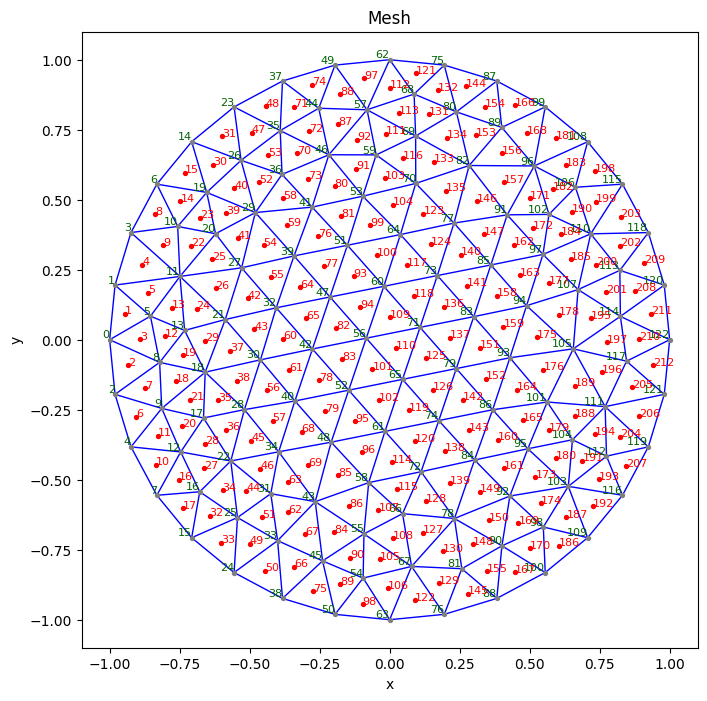

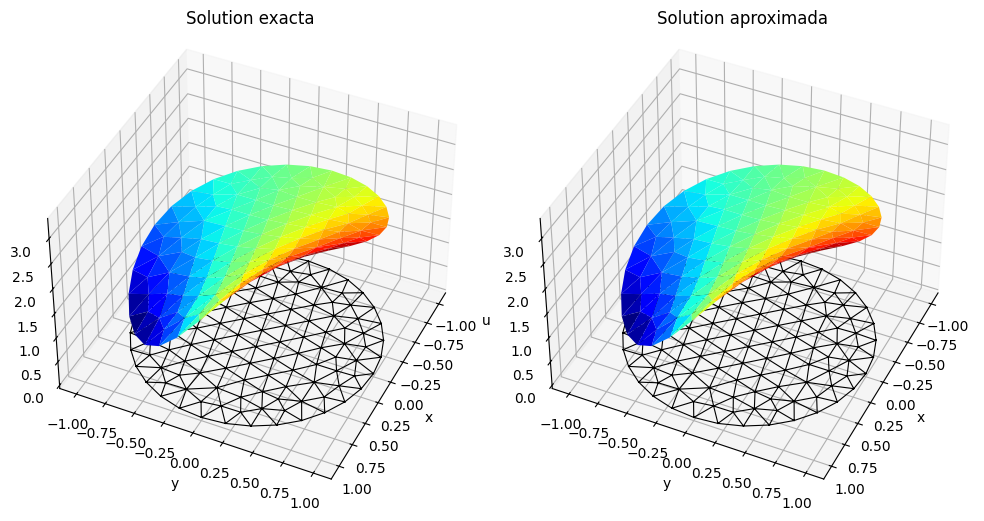

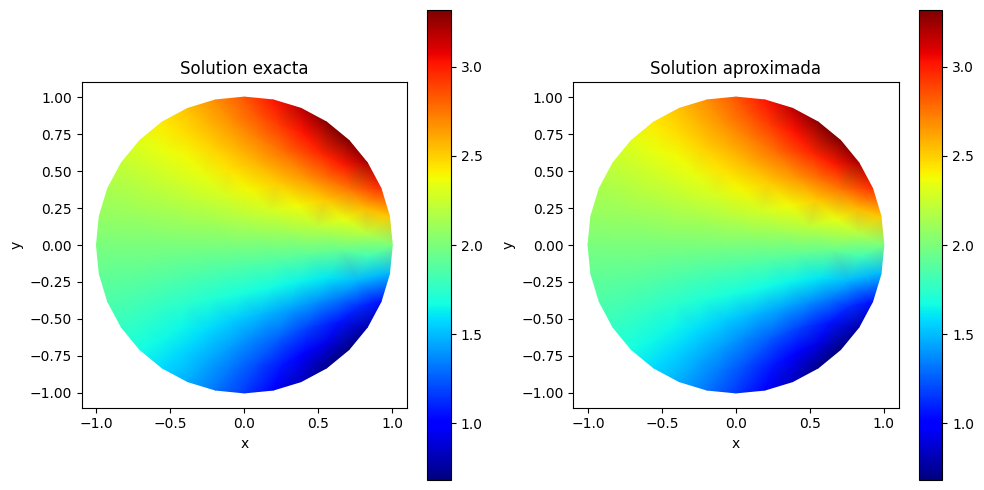

AttributeError: 'Axes' object has no attribute 'colorbar'

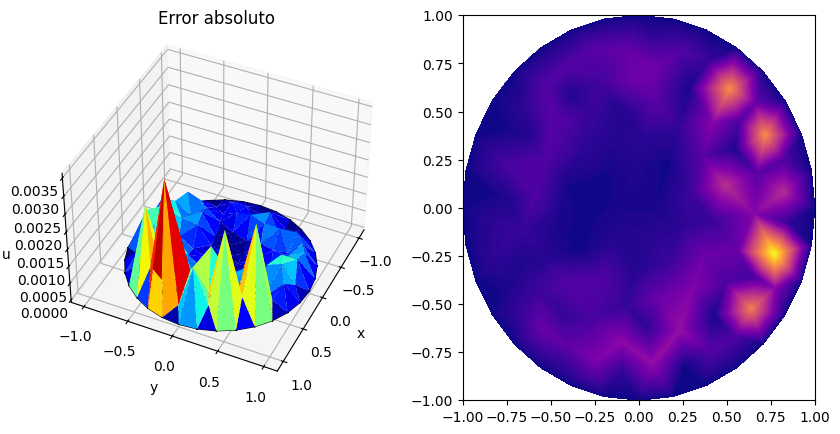

In [35]:
"""
FEM_Laplace2D_Dirichlet

"""

if __name__ == "__main__":

    #---------------------------------------------------------------------------
    # Mesh
    lc = 0.2
    #mesh = pygmsh_cuadrado(lc)
    mesh = pygmsh_circulo(lc)
    #mesh = pygmsh_anillo(lc)
    #mesh = pygmsh_lavadora(lc)
    #mesh = pygmash_smile(lc)
    # ---------
    mesh = read_data_clean(mesh)
    # ---------------------
    CoorX  = mesh.POS[:, 0]
    CoorY  = mesh.POS[:, 1]
    TriI   = mesh.TRI[:, :]
    bndry  = mesh.BDY
    # ---------------------
    tri = TriI[:, :3].astype(int)
    nodo1 = tri[:, 0]
    nodo2 = tri[:, 1]
    nodo3 = tri[:, 2]
    # ---------------------
    nNod  = len(CoorX)
    nElem = len(nodo1)
    # ---------------------
    # Imprimir
    print(f"Number of elements : {nElem}")
    print(f"Number of nodes    : {nNod}")
    print(f"First few nodes:\n{mesh.POS[:5]}")
    print(f"First few elements:\n{mesh.TRI[:5]}")

    #---------------------------------------------------------------------------
    # Condiciones de frontera
    M = len(bndry)
    DirichletA = bndry
    nDirA = M
    print(f"Number of nodes              : {nNod}")
    print(f"Number of boundary conditions: {M}")
    print(f"Number of Dirichlet nodes.   : {nDirA}")
    print(f"Dirichlet nodes:\n{DirichletA[:]}")

    #---------------------------------------------------------------------------
    # Solve
    tstart = time.time()
    u = poisson_2d_fem(nNod, nDirA, nElem,
                       nodo1, nodo2, nodo3, CoorX, CoorY,
                       DirichletA)
    tend = time.time()
    print("------------------------------------------------")
    print(f"System solved in {tend - tstart:.4f} s")

    #---------------------------------------------------------------------------
    # Errorres

    uE = u_exact(CoorX,CoorY)
    Err = np.abs(u - uE)
    ErrMax = np.max(Err)
    print("------------------------------------------------")
    print(f"lc = {lc}, Error maximo: {ErrMax}")
    print("------------------------------------------------")

    #---------------------------------------------------------------------------
    # Graficar la malla

    triang = mtri.Triangulation(CoorX, CoorY, tri) # Para graficar con triplot

    # ---------------------
    # Graficar
    plt.figure(figsize=(8, 8))
    plt.triplot(triang, color='blue', linewidth=1)
    plt.scatter(CoorX, CoorY, color='gray', s=8, zorder=5)
    # Indices de nodos
    for i, (xi, yi) in enumerate(zip(CoorX, CoorY)):
        plt.text(xi, yi, str(i), color='darkgreen', fontsize=8, ha='right', va='bottom')
    # Dibujar centroides y enumerarlos
    centroids = np.column_stack([CoorX[TriI].mean(axis=1),CoorY[TriI].mean(axis=1)])
    plt.scatter(centroids[:,0], centroids[:,1], color='red', s=8)
    for i, (cx, cy) in enumerate(centroids):
        plt.text(cx, cy, str(i+1), color='red', fontsize=8)
    plt.gca().set_aspect('equal')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Mesh')
    plt.show()

    #---------------------------------------------------------------------------
    # Graficar los resultados

    # ---------------------
    # Solucion 3D
    fig = plt.figure(figsize=(10, 5))

    # Exacta
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.triplot(triang, color="black", linewidth=0.8)
    ax1.plot_trisurf(triang, uE, linewidth=0.0, antialiased=True,cmap='jet',shade=True, edgecolor='none')
    ax1.view_init(elev=41, azim=25)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')
    ax1.set_title('Solution exacta')

    # Aproximada
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    ax1.triplot(triang, color="black", linewidth=0.8)
    ax1.plot_trisurf(triang, u, linewidth=0.0, antialiased=True,cmap='jet',shade=True, edgecolor='none')
    ax1.view_init(elev=41, azim=25)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')
    ax1.set_title('Solution aproximada')

    plt.tight_layout()
    plt.show()

    # ---------------------
    # Solucion 2D (top view)
    fig = plt.figure(figsize=(10, 5))

    # Exacta
    ax2 = fig.add_subplot(1, 2, 1)
    tpc = ax2.tripcolor(triang, uE, shading='gouraud', cmap='jet')
    plt.gca().set_aspect('equal')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Solution exacta')
    fig.colorbar(tpc, ax=ax2)

    # Aproximada
    ax2 = fig.add_subplot(1, 2, 2)
    tpc = ax2.tripcolor(triang, u, shading='gouraud', cmap='jet')
    plt.gca().set_aspect('equal')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Solution aproximada')
    fig.colorbar(tpc, ax=ax2)

    plt.tight_layout()
    plt.show()

    # ---------------------
    # Errores abolsutos
    fig = plt.figure(figsize=(10, 5))

    # 3D plot
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.triplot(triang, color="black", linewidth=0.8)
    ax1.plot_trisurf(triang, Err, linewidth=0.0, antialiased=True,cmap='jet',shade=True, edgecolor='none')
    #ax1.tricontourf(CoorX, CoorY, Err, levels=100, cmap='plasma')
    ax1.view_init(elev=41, azim=25)
    ax1.set_xlabel('x')
    ax1.set_ylabel('y')
    ax1.set_zlabel('u')
    ax1.set_title('Error absoluto')

    # 2D plot (top view)
    ax2 = fig.add_subplot(1, 2, 2)
    #tpc = ax2.tripcolor(triang, Err, shading='gouraud', cmap='jet')
    ax2.tricontourf(CoorX, CoorY, Err, levels=100, cmap='plasma')
    ax2.colorbar(label='Error absoluto')
    plt.gca().set_aspect('equal')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title('Error absoluto')
    # fig.colorbar(tpc, ax=ax2)

    plt.tight_layout()
    plt.show()

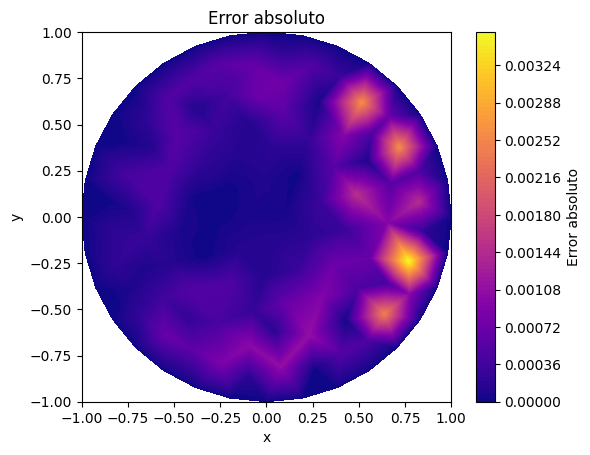

In [39]:
#tpc = ax2.tripcolor(triang, Err, shading='gouraud', cmap='jet')
plt.tricontourf(CoorX, CoorY, Err, levels=100, cmap='plasma')
plt.colorbar(label='Error absoluto')
plt.gca().set_aspect('equal')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Error absoluto')
    # fig.colorbar(tpc, ax=ax2)

plt.savefig('FEM_Abs.png')
plt.show()